<a href="https://colab.research.google.com/github/ast-abo/ShotTracker/blob/Export-Model/ShotTrackerModelTraingScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install roboflow
from roboflow import Roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 143.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.4/107.7 GB disk)


In [4]:
import os
import shutil

!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://hc-cdn.hel1.your-objectstorage.com/s/v3/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpeg' save=True

# Define paths
OutputDirectory = "runs/detect/predict"
OldFileName = "9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpg"  # The original file name
NewFileName = "ball.jpg"  # The desired new name

# Rename the file
OldFilePath = os.path.join(OutputDirectory, OldFileName)
NewFilePath = os.path.join(OutputDirectory, NewFileName)
print(OldFilePath)


try:
    shutil.move(OldFilePath, NewFilePath)
    print(f"File renamed to {NewFilePath}")
except Exception as e:
    print(f"Error renaming file: {e}")

100% 5.35M/5.35M [00:00<00:00, 101MB/s]
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 66.9k/66.9k [00:00<00:00, 168kB/s]
image 1/1 /content/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpeg: 640x448 1 person, 1 clock, 107.9ms
Speed: 10.2ms preprocess, 107.9ms inference, 23.5ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict
runs/detect/predict/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpg
File renamed to runs/detect/predict/ball.jpg


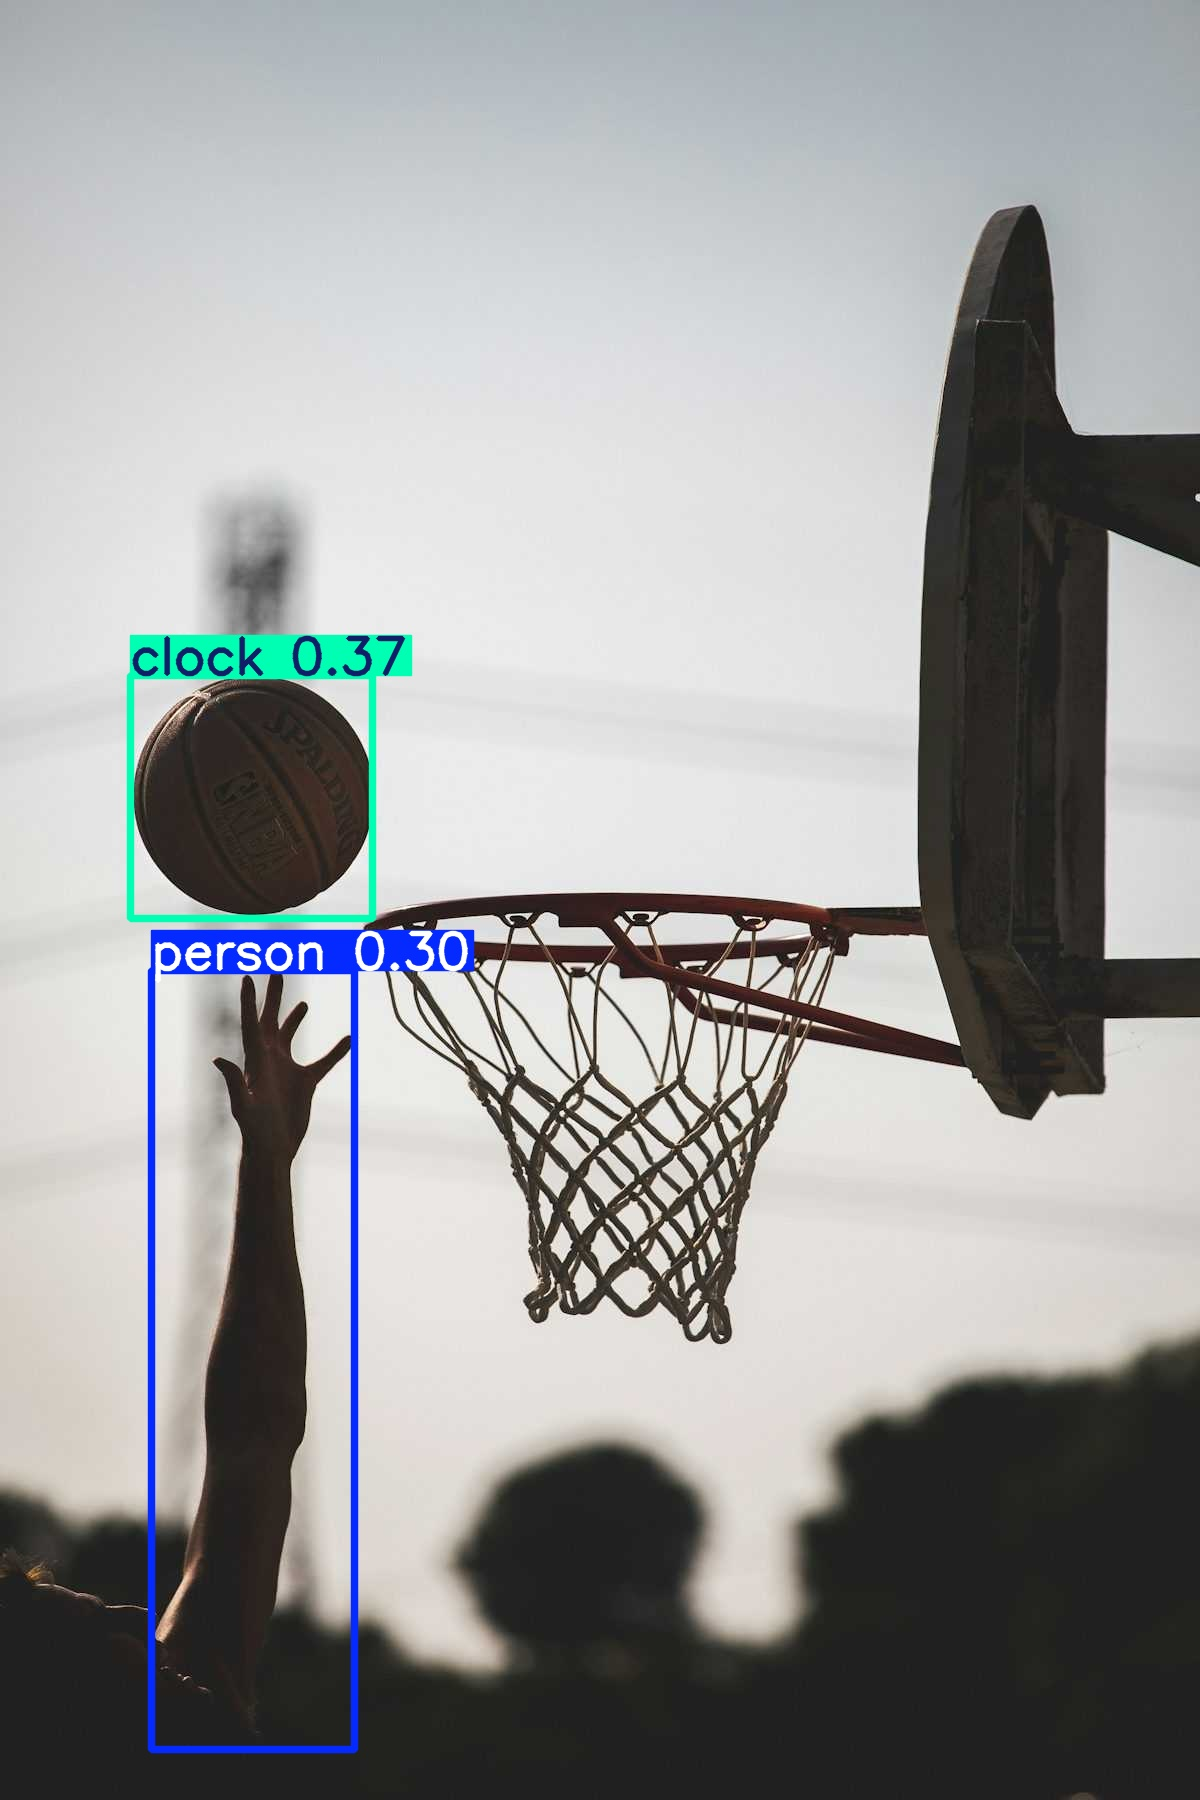

In [5]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/ball.jpg', width=600)

In [14]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://hc-cdn.hel1.your-objectstorage.com/s/v3/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x448 1 person, 1 clock, 97.2ms
Speed: 2.7ms preprocess, 97.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


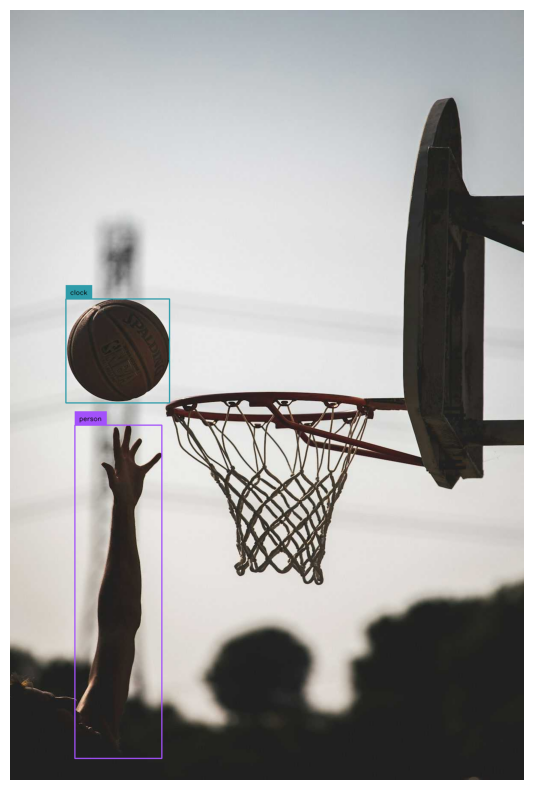

In [7]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)


sv.plot_image(annotated_image, size=(10, 10))

In [8]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

rf = Roboflow(api_key="NLWnQPigGaE8pl98gFYh")
project = rf.workspace("icespace").project("shot-tracker-ik6bf")
version = project.version(2)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Shot-Tracker-2 in yolov11:: 100%|██████████| 52/52 [00:00<00:00, 3283.46it/s]


In [9]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 122MB/s]
New https://pypi.org/project/ultralytics/8.3.120 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Shot-Tracker-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None

In [10]:
!ls {HOME}/runs/detect/train/

args.yaml					    R_curve.png
confusion_matrix_normalized.png			    results.csv
confusion_matrix.png				    results.png
events.out.tfevents.1745960918.0c2d6a7138b1.2015.0  train_batch0.jpg
F1_curve.png					    train_batch1.jpg
labels_correlogram.jpg				    train_batch2.jpg
labels.jpg					    val_batch0_labels.jpg
P_curve.png					    val_batch0_pred.jpg
PR_curve.png					    weights


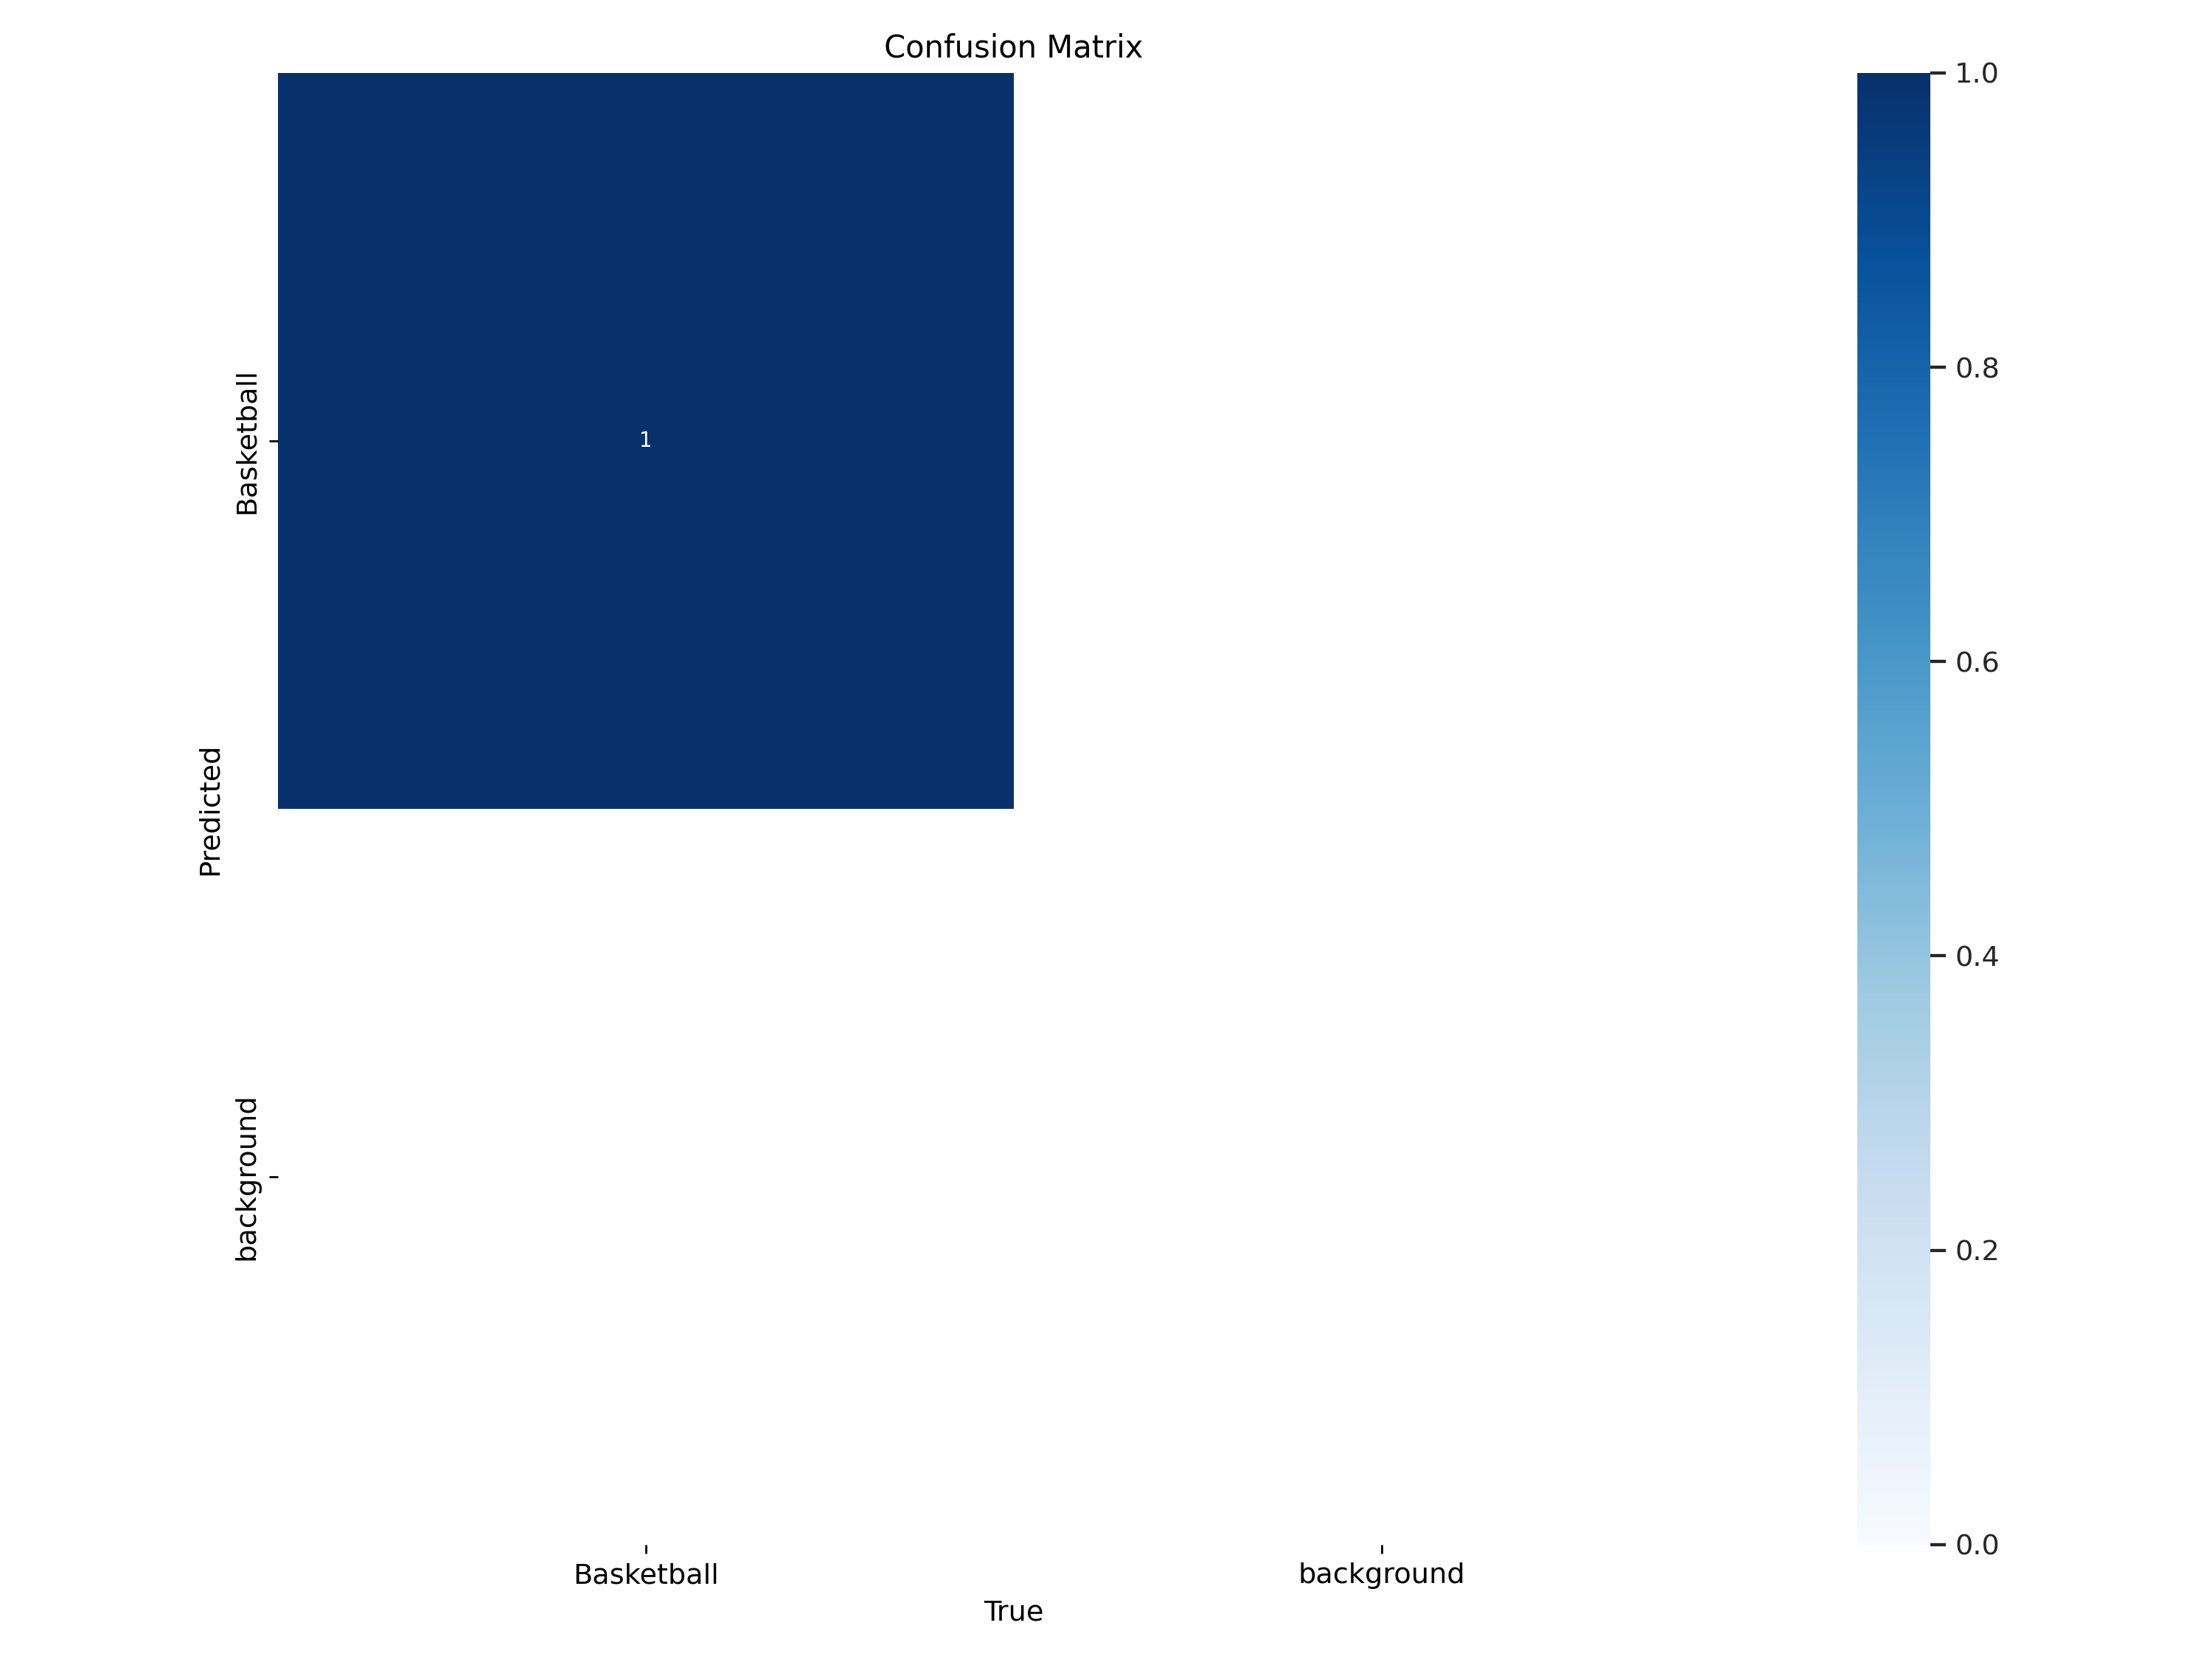

In [11]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

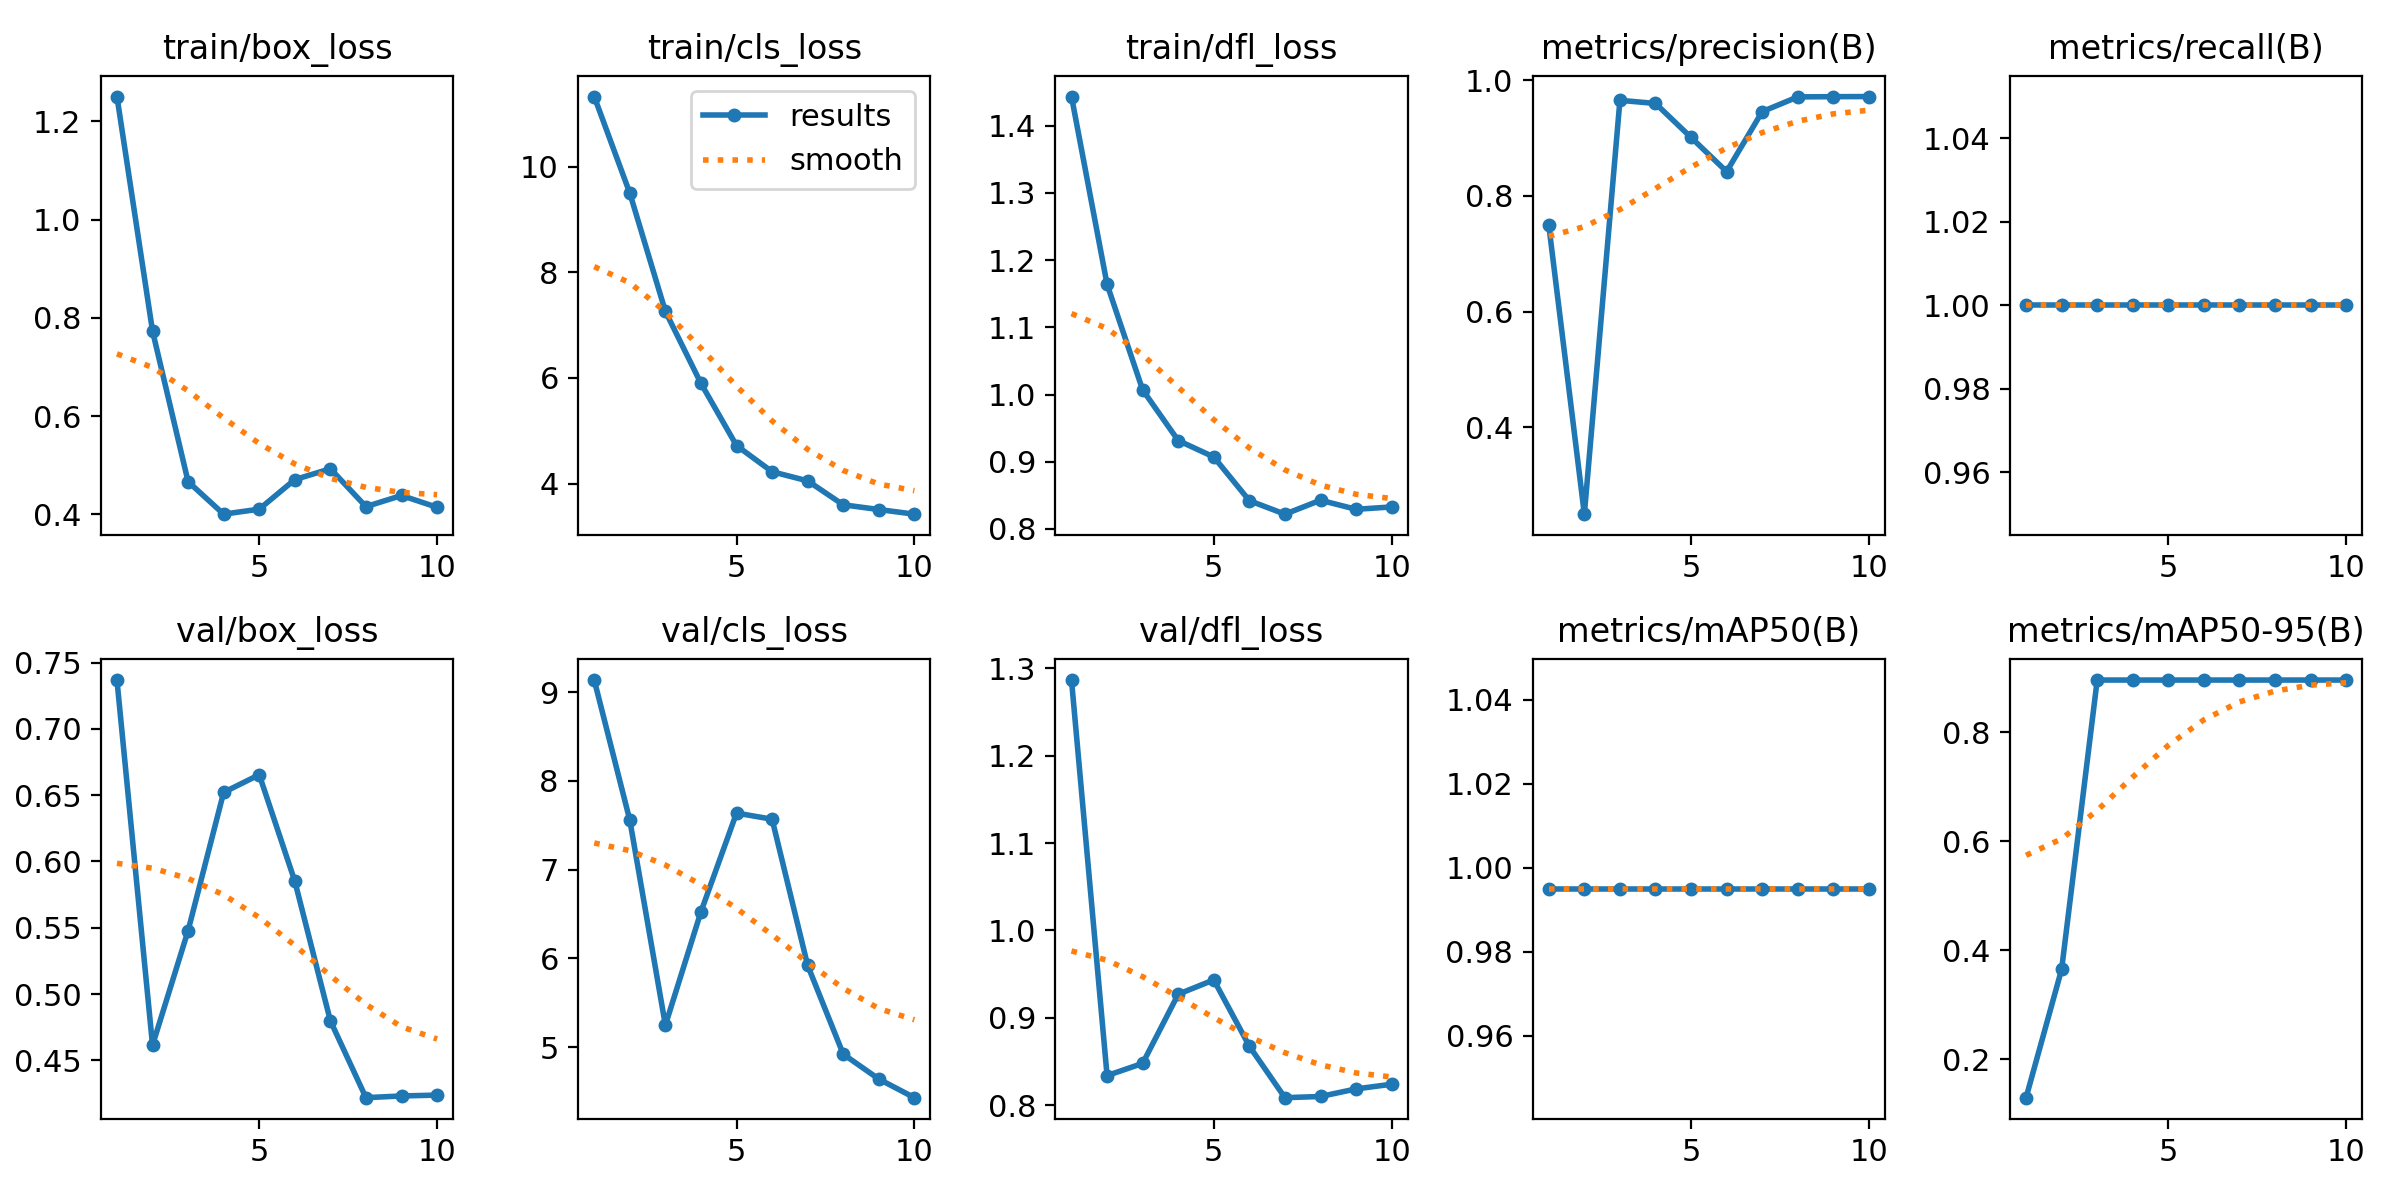

In [12]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

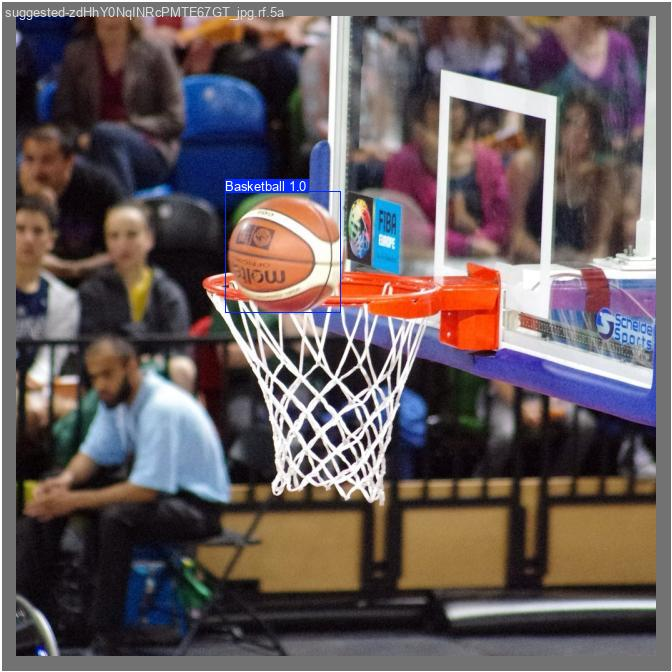

In [13]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [14]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Shot-Tracker-2/valid/labels.cache... 1 images, 0 backgrounds, 0 corrupt: 100% 1/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  2.27it/s]
                   all          1          1      0.972          1      0.995      0.895
Speed: 0.8ms preprocess, 389.1ms inference, 0.0ms loss, 43.9ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [15]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

An error occured when getting the model upload URL: This version already has a trained model. Please generate and train a new version in order to upload model to Roboflow.


In [4]:
!pip install inference

['suggested-XWTvfDY1tLS473huZiKG_jpg.rf.e6aa4bff9f99c3b197c11a6d7d165961.jpg']
Running inference on suggested-XWTvfDY1tLS473huZiKG_jpg.rf.e6aa4bff9f99c3b197c11a6d7d165961.jpg


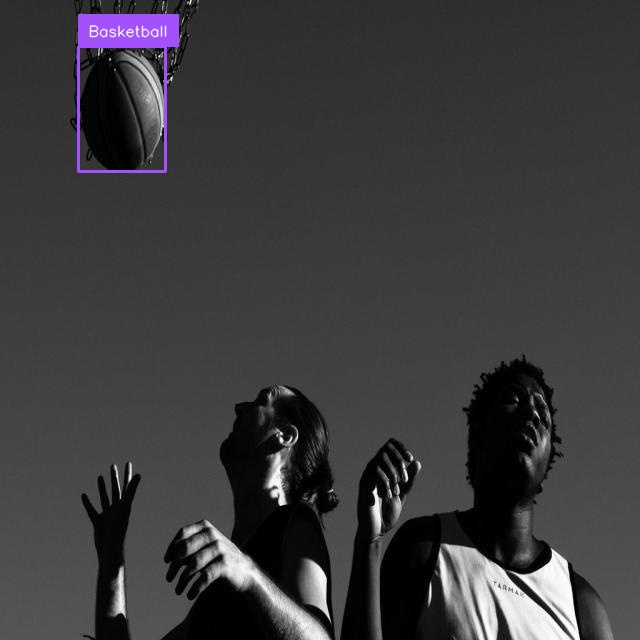

In [5]:
import os, random, cv2
import supervision as sv
import IPython
import inference

# Location of test set images
test_set_loc = '/content/datasets/Shot-Tracker-2/test/images'
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))
    if image is None:
      continue

    print("Running inference on " + img_name)

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [15]:
# Load the YOLO11 model

# Export the model to TFLite format
model.export(format="tflite")

# Load the exported TFLite model
# tflite_model = YOLO("yolo11n_float32.tflite")

# Run inference
# results = tflite_model("https://ultralytics.com/images/bus.jpg")

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.4 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1

100%|██████████| 1.11M/1.11M [00:00<00:00, 27.0MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 61.73file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 1.2s, saved as 'yolo11n.onnx' (10.3 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 36.8s, saved as 'yolo11n_saved_model' (26.0 MB)

TensorFlow Lite: starting export with tensorflow 2.18.0...
TensorFlow Lite: export success ✅ 0.0s, saved as 'yolo11n_saved_model/yolo11n_float32.tflite' (10.3 MB)

Export complete (37.1s)
Results saved to /content
Predict:         yolo predict task=detect model=yolo11n_saved_model/yolo11n_float32.tflite imgsz=640  
Validate:        yolo val task=detect model=yolo11n_saved_model/yolo11n_float32.tflite imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


'yolo11n_saved_model/yolo11n_float32.tflite'